In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50


In [20]:
cu_df= pd.read_csv("Data_Marketing_Customer_Analysis_Round3copy.csv")

numericals = cu_df.select_dtypes(include=[np.number])
categoricals = cu_df.select_dtypes(exclude=[np.number])

X = cu_df.drop('total_claim_amount', axis=1)
y = cu_df.total_claim_amount

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)


/var/folders/p4/_ylldw792tx5lq22msk41v500000gn/T/ipykernel_19168/3188246930.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categoricalX = X.select_dtypes(np.object)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(cu_df.drop('total_claim_amount', axis=1), cu_df['total_claim_amount'], test_size=0.2, random_state=42)


In [22]:
from scipy.stats import iqr
def remove_outliers(cu_df):
    for c in cu_df.columns:
            pct_75 = np.percentile(cu_df[c], 75)
            pct_25 = np.percentile(cu_df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(cu_df[c])
            lower_bound = pct_25 - 1.5*iqr(cu_df[c])
            condition = (cu_df[c] < upper_bound) & (cu_df[c] > lower_bound)
            cu_df[c] = cu_df[c][condition]  # Filter out the outliers
    return cu_df

In [23]:
X = pd.concat([pd.get_dummies(X[categoricalX.columns],drop_first=True),
               remove_outliers(X[numericalX.columns])],
              axis=1)

/var/folders/p4/_ylldw792tx5lq22msk41v500000gn/T/ipykernel_19168/3409981166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu_df[c] = cu_df[c][condition]  # Filter out the outliers


In [14]:
#X.isna().any()

region_east                      False
region_north west                False
region_west region               False
response_yes                     False
coverage_extended                False
                                 ...  
monthly_premium_auto              True
months_since_last_claim          False
months_since_policy_inception    False
number_of_open_complaints         True
number_of_policies                True
Length: 108, dtype: bool

In [17]:
#na_idcs = X[X.isna().any(axis=1)].index
#X = pd.DataFrame(X).drop(na_idcs)
#y = pd.DataFrame(y).drop(na_idcs)

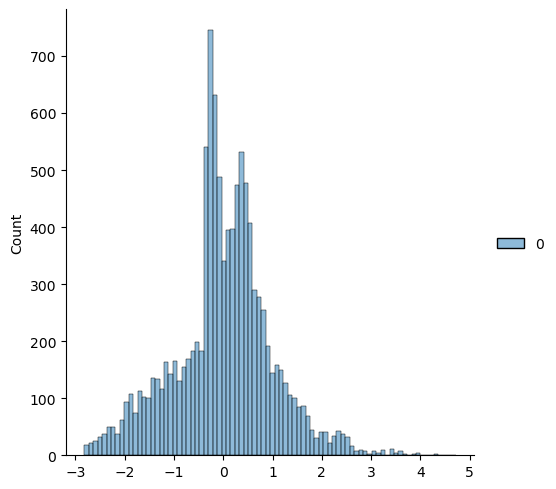

In [26]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

pt = PowerTransformer()
totalclaim_transformed=pt.fit_transform(cu_df['total_claim_amount'].to_numpy().reshape(-1,1))
sns.displot(totalclaim_transformed)

In [27]:
ct = ColumnTransformer([("pt", pt, list(numericalX.columns))],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.1s


In [28]:
X_train = pd.DataFrame(X_train_ct)
X_test_ct

,pt__customer_lifetime_value,pt__income,pt__monthly_premium_auto,pt__months_since_last_claim,pt__months_since_policy_inception,pt__number_of_open_complaints,pt__number_of_policies
0,-0.313260,0.865977,-1.535708,-1.948892,1.036302,-0.504231,1.126951
1,0.678873,-0.257692,1.005081,-0.349713,1.036302,-0.504231,0.509194
2,-1.092136,0.721535,-0.161073,-1.948892,-0.016501,-0.504231,-1.148679
3,-0.245562,0.464816,-1.251406,0.579080,-2.088503,1.939188,0.509194
4,0.550119,-0.094361,2.002861,-1.116508,-0.927869,1.939188,-1.148679
...,...,...,...,...,...,...,...
2133,-0.852546,-1.825015,0.433657,1.386884,-0.641640,-0.504231,-1.148679
2134,0.525369,0.811961,0.713690,1.038512,-1.194401,-0.504231,0.509194
2135,-0.649299,1.230545,0.939407,-0.829156,0.886206,-0.504231,-1.148679
2136,0.326995,-0.700978,0.398393,0.326979,-0.228232,-0.504231,1.572580


In [29]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()   #stats models is the sm 
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     556.6
Date:                Tue, 11 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:54:59   Log-Likelihood:                -59139.
No. Observations:                8551   AIC:                         1.183e+05
Df Residuals:                    8543   BIC:                         1.183e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        432.7827      2.640    163.959      0.0

In [30]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)

LinearRegression()

In [31]:
y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['total_claim_amount'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_ct),columns = ['total_claim_amount'])

In [32]:
model.coef_

array([ -2.7161423 , -36.29813178, 162.08425856,   2.07457989,
        -1.29805366,  -2.8920425 ,   0.96297423])

In [33]:
model.intercept_

432.7827154718543

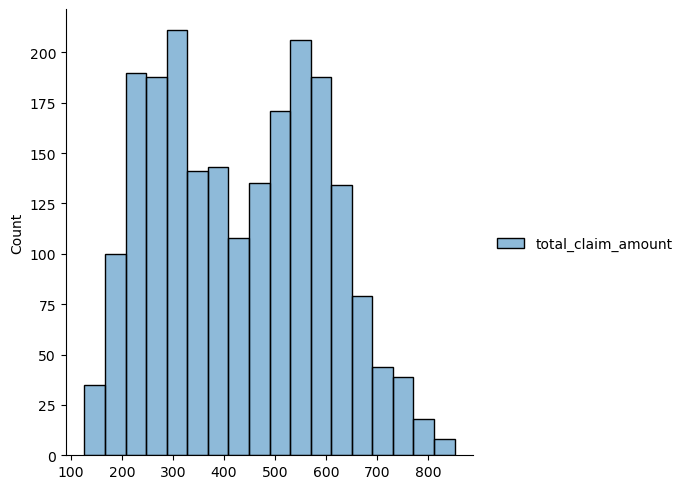

In [38]:
sns.displot(y_pred)